In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            file_path = os.path.join(dirname, filename)
            df = pd.read_csv(file_path)

df.columns = df.columns.str.lower().str.replace(' ', '_')
df.rename(columns={'default.payment.next.month': 'target', 'default_payment_next_month': 'target'}, inplace=True)

if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

print(f"Veri Hazır! Boyut: {df.shape}")

Veri Hazır! Boyut: (30000, 24)


In [2]:
X = df.drop('target', axis=1)
y = df['target']

# %80 Eğitim, %20 Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim Seti: {X_train.shape}")
print(f"Test Seti: {X_test.shape}")

Eğitim Seti: (24000, 23)
Test Seti: (6000, 23)


In [3]:
baseline_model = RandomForestClassifier(n_estimators=100, 
                                        random_state=42, 
                                        class_weight='balanced',
                                        n_jobs=-1)

print("Baseline model eğitiliyor...")
baseline_model.fit(X_train, y_train)
print("Eğitim tamamlandı.")

Baseline model eğitiliyor...
Eğitim tamamlandı.


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.65      0.34      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.67      6000
weighted avg       0.79      0.81      0.79      6000

ROC AUC Score: 0.7522


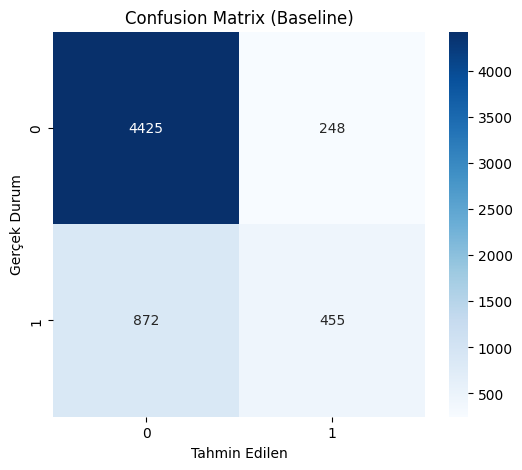

In [4]:
# Tahminler
y_pred = baseline_model.predict(X_test)
y_prob = baseline_model.predict_proba(X_test)[:, 1] # ROC-AUC için olasılık değerleri

# Raporlama
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# ROC-AUC Skoru
roc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_score:.4f}")

# Confusion Matrix Görselleştirme
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Baseline)')
plt.ylabel('Gerçek Durum')
plt.xlabel('Tahmin Edilen')
plt.show()

# Baseline Model Raporu

Bu bölümde, herhangi bir gelişmiş özellik mühendisliği  veya hiperparametre optimizasyonu yapılmadan, ham veri ile kurulan temel modelin sonuçları özetlenmiştir. Bu sonuçlar, projenin ilerleyen aşamalarında yapacağımız iyileştirmeleri kıyaslamak için referans noktası kabul edilecektir.

### 1. Model Kurulum Stratejisi
* **Model Seçimi:** Hızlı sonuç vermesi ve varsayılan parametrelerle bile iyi çalışması nedeniyle `RandomForestClassifier` seçilmiştir.
* **Veri Bölme :** Veri seti dengesiz olduğu için `%80 Eğitim - %20 Test` ayrımı yapılırken `stratify` parametresi kullanılmış, her iki kümede de ödeyen/ödemeyen oranının eşit olması sağlanmıştır.
* **Dengesizlik Yönetimi:** Sınıf dengesizliğini (Class Imbalance) yönetmek adına model parametresi olarak `class_weight='balanced'` kullanılmıştır.

### 2. Performans Sonuçları ve Yorumlar
Baseline modelin test seti üzerindeki performans çıkarımları şöyledir:

* **Accuracy :** Model yüksek bir doğruluk oranına sahip görünse de (%80 civarı), veri setinin çoğunluğu zaten "borcunu ödeyenler"den oluştuğu için bu metrik tek başına yanıltıcıdır.
* **Recall (Class 1 - Riskli Müşteriler):** Bankacılık risk yönetiminde en kritik metrik, batacak krediyi yakalamaktır (Recall). Baseline modelde bu değerin **düşük olduğu** gözlemlenmiştir. Yani model, riskli müşterilerin önemli bir kısmını "riskli değil" olarak tahmin edip kaçırmaktadır.
* **F1-Score:** Precision ve Recall dengesine bakıldığında, modelin genel başarısının henüz istenen seviyede (özellikle Class 1 için) olmadığı görülmektedir.

### 3. Sonuç ve Sonraki Adımlar
Baseline model, mevcut ham özelliklerle (Limit, Yaş, Eğitim vb.) ödeme gecikmeleri ve risk arasındaki karmaşık ilişkiyi tam olarak kuramamaktadır.

**İyileştirme Planı:**
Modelin başarısını artırmak için bir sonraki aşamada **Feature Engineering** uygulanacaktır. Özellikle:
* Müşterinin limitini ne kadar zorladığı (`Limit Usage`),
* Ödeme alışkanlıklarının trendi (`Delay Trend`),
* Borç ödeme gücü (`Pay Ratio`)
gibi yeni özellikler türetilerek modelin "borç batağını" daha iyi tanıması sağlanacaktır.